In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

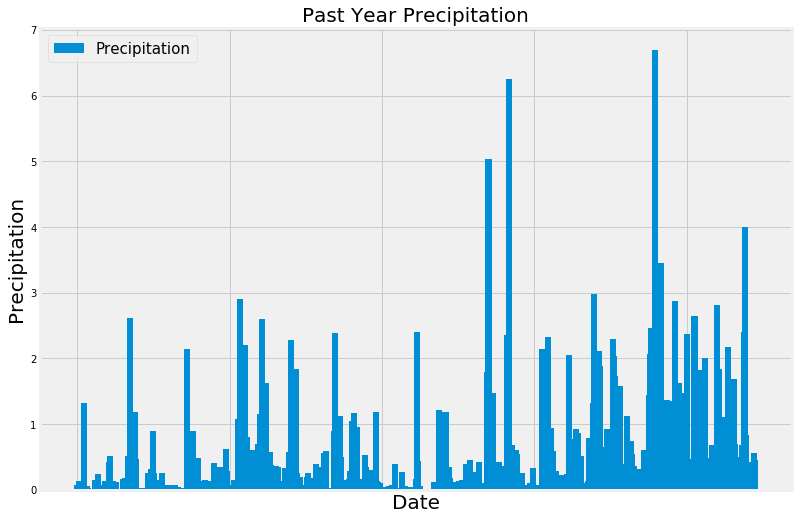

<Figure size 432x288 with 0 Axes>

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the databases
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(last_date)
last_date_1_year_ago=dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>last_date_1_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(precipitation)
prcp_df.set_index('date',inplace=True)
prcp_df=prcp_df.rename(columns={
    "prcp":"Precipitation"
})
# Sort the dataframe by date
prcp_df.sort_values(by=['date'])
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
f, ax = plt.subplots(figsize=(12,8.5))
x_axis=np.arange(0, len(prcp_df['Precipitation']))
plt.bar(x_axis,prcp_df['Precipitation'],width=20)
plt.title("Past Year Precipitation",size=20)
plt.xlabel("Date",size=20)
plt.ylabel("Precipitation",size=20)
plt.tick_params(
    axis='x',
    labelbottom=False)
plt.legend(['Precipitation'],prop={'size': 15})
plt.show()
plt.savefig('Results/Fig1.png')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary=pd.DataFrame(prcp_df['Precipitation'].describe())
summary

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by("count").all()

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_avg=session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').scalar()
most_active_min=session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').scalar()
most_active_max=session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').scalar()
print(most_active_min,most_active_max,most_active_avg)

54.0 85.0 71.66378066378067


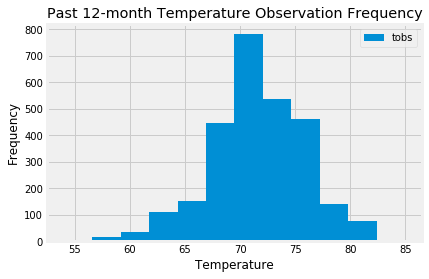

In [77]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_freq=session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').all()
# temp_freq=pd.DataFrame(temp_freq)
temp_df=pd.DataFrame(temp_freq)
temp_df.plot.hist(bins=12,grid=True)
plt.xlabel ('Temperature')
plt.title('Past 12-month Temperature Observation Frequency')
plt.savefig('Results/Fig2.png')

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


Trip day: 3.2-3.10

In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
result=calc_temps('2017-03-02', '2017-03-10')
result

[(62.0, 70.50909090909092, 78.0)]

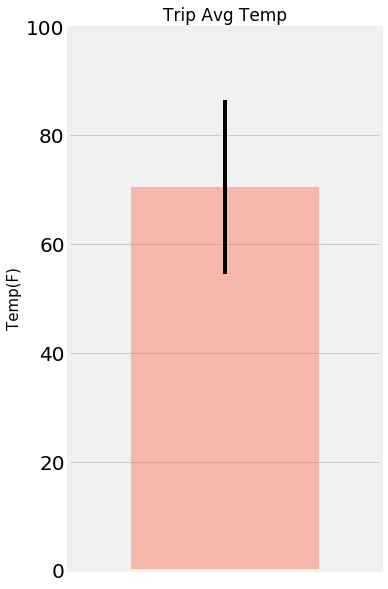

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis=np.arange(len([result[0][1]]))
error=result[0][2]-result[0][0]
f, ax = plt.subplots(figsize=(5,10))
plt.bar(x_axis,result[0][1],yerr=error,width=0.6,color="tomato",alpha=0.4)
plt.xlim(-0.5,0.5)
plt.ylim(0,100)
plt.title("Trip Avg Temp",size=17)
plt.ylabel("Temp(F)",size=15)
plt.grid
plt.tick_params(axis='y',which='major',labelsize=20)
plt.tick_params(axis='x',labelbottom=False)
ax.xaxis.grid()
plt.show()
plt.savefig('Results/Fig3.png')

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).group_by(Measurement.station).filter(Measurement.station==Station.station).filter(Measurement.date>'2017-03-01').filter(Measurement.date<'2017-03-11').all()
total_prcp

[('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  3.5299999999999994),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.63),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.5000000000000002),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  0.5800000000000001),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.2699999999999996),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.5499999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.73)]

## Optional Challenge Assignment

In [44]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start_date=dt.datetime.strptime("2018-03-02","%Y-%m-%d")
end_date=dt.datetime.strptime("2018-03-10","%Y-%m-%d")
# Use the start and end date to create a range of dates
date_range=[dt.datetime.strftime(start_date+dt.timedelta(days=x),"%Y-%m-%d") for x in range((end_date-start_date).days)]
date_only_range=[dt.datetime.strftime(start_date+dt.timedelta(days=x),"%m-%d") for x in range((end_date-start_date).days)]
# Stip off the year and save a list of %m-%d strings
for x in date_only_range:
    normal=daily_normals(x)
    list=(normal[0][0],normal[0][1],normal[0][2])
    normals.append(list)
normals

[(61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0)]

In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df=pd.DataFrame(normals,columns=["tmin",'tavg','tmax'],index=date_range)
normal_df

,tmin,tavg,tmax
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0
2018-03-06,60.0,69.203390,76.0
2018-03-07,60.0,69.172414,78.0
2018-03-08,59.0,68.724138,78.0
2018-03-09,57.0,68.561404,75.0


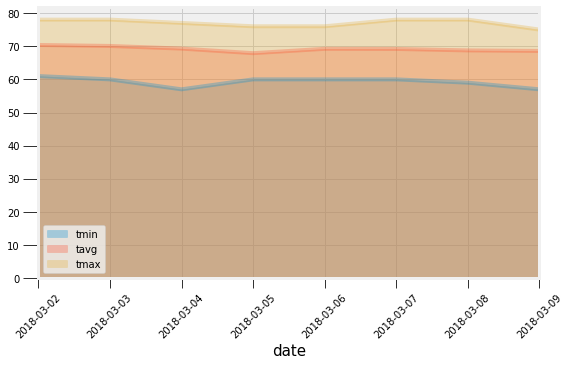

<Figure size 432x288 with 0 Axes>

In [76]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(alpha=0.3, stacked=False,figsize=(8,5))
plt.xlabel("date",size=15)
plt.tick_params(axis='x',rotation=45,size=10)
plt.tick_params(axis='y',size=15)
plt.show()
plt.savefig('Results/Fig4.png')